In [1]:
%matplotlib inline
from config_calc import *

import matplotlib
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
plt.rcParams['mathtext.default']='regular'

import cmocean
import plot_tools
import proc_cesm_le

In [2]:
%%time
files = os.path.join(diro['out'],'region_0glb_1trp_2hlt_upper1000m.ens_i_???.nc')
ds = xr.open_mfdataset(files,concat_dim='ens',decode_times=False)
ds = ds.drop([v for v in ds if v not in ['O2','AOU','O2sat','TEMP','IAGE','vol_sum']])
print ds

<xarray.Dataset>
Dimensions:  (ens: 33, region: 3, time: 182)
Dimensions without coordinates: ens, region, time
Data variables:
    O2       (ens, time, region) float64 151.6 79.75 195.3 nan nan nan 151.5 ...
    AOU      (ens, time, region) float64 144.8 202.4 109.7 nan nan nan 144.8 ...
    TEMP     (ens, time, region) float64 8.548 10.78 7.192 nan nan nan 8.548 ...
    IAGE     (ens, time, region) float64 147.5 188.8 122.3 nan nan nan 147.6 ...
    O2sat    (ens, time, region) float64 296.4 282.1 305.0 nan nan nan 296.4 ...
    vol_sum  (ens, region) float64 3.476e+23 1.316e+23 2.16e+23 3.476e+23 ...
CPU times: user 8.55 s, sys: 1.45 s, total: 10 s
Wall time: 17.7 s


In [3]:
baseline = ds.isel(time=slice(0,20)).mean(dim='time')
baseline

<xarray.Dataset>
Dimensions:  (ens: 33, region: 3)
Dimensions without coordinates: ens, region
Data variables:
    O2       (ens, region) float64 151.5 79.43 195.3 151.4 79.71 195.1 151.4 ...
    AOU      (ens, region) float64 145.0 202.8 109.7 144.9 202.5 109.9 145.0 ...
    TEMP     (ens, region) float64 8.538 10.76 7.186 8.55 10.77 7.2 8.543 ...
    IAGE     (ens, region) float64 148.0 189.5 122.7 147.9 189.4 122.7 147.9 ...
    O2sat    (ens, region) float64 296.4 282.2 305.1 296.4 282.2 305.0 296.4 ...
    vol_sum  (ens, region) float64 3.476e+23 1.316e+23 2.16e+23 3.476e+23 ...

In [4]:
delta = ds - baseline
delta

<xarray.Dataset>
Dimensions:  (ens: 33, region: 3, time: 182)
Dimensions without coordinates: ens, region, time
Data variables:
    O2       (ens, time, region) float64 0.1272 0.317 0.01158 nan nan nan ...
    AOU      (ens, time, region) float64 -0.186 -0.4159 -0.04592 nan nan nan ...
    TEMP     (ens, time, region) float64 0.009687 0.01666 0.005436 nan nan ...
    IAGE     (ens, time, region) float64 -0.4847 -0.6964 -0.3558 nan nan nan ...
    O2sat    (ens, time, region) float64 -0.05879 -0.09892 -0.03434 nan nan ...
    vol_sum  (ens, region) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

### load data from Taka
Obs and CMIP5 data are in different format. cmip_o2heat.m is the script to use. Below is about the model output. 

o2_global: L x M x N array 
L = cmip5 models (1=GFDL-ESM2M; 2=GFDL-ESM2G; 3=HADGEM; 4=IPSL-CM5A-LR; 5=IPSL-CM5A-MR, 6=IPSL-CM5B-LR; 7=MPI-ESM-LR; 8=MPI-ESM-MR; 9=CESM1-BGC)
M = time (annual)
N = domain of integration (1 = high lat; 2 = low lat; 3 = global);

T_global: the same as o2_global

sat_global: the same as o2_global

import scipy.io as sio
matdata = sio.loadmat('taka_fig/hc_basin.mat',
                       struct_as_record = False,
                       squeeze_me = True)

yr = xr.DataArray(matdata['yr'],dims=('time'))
hc = xr.DataArray(matdata['hc'],dims=('time'))
matdata['hc'].shape


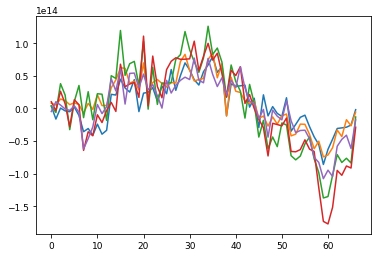

In [12]:
matdata = sio.loadmat('taka_fig/o2_inventory_normalized_2.mat',
                       struct_as_record = False,
                       squeeze_me = True)
plt.plot(matdata['o2V'][:,:].T)

### compute an integral from the mean

In [6]:
deltai = delta * ds.vol_sum * 1e-6
print deltai

<xarray.Dataset>
Dimensions:  (ens: 33, region: 3, time: 182)
Dimensions without coordinates: ens, region, time
Data variables:
    O2       (ens, time, region) float64 4.421e+16 4.171e+16 2.501e+15 nan ...
    AOU      (ens, time, region) float64 -6.464e+16 -5.473e+16 -9.918e+15 ...
    TEMP     (ens, time, region) float64 3.367e+15 2.193e+15 1.174e+15 nan ...
    IAGE     (ens, time, region) float64 -1.685e+17 -9.162e+16 -7.687e+16 ...
    O2sat    (ens, time, region) float64 -2.043e+16 -1.302e+16 -7.417e+15 ...
    vol_sum  (ens, region) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...


In [7]:
deltaa = delta.mean(dim='ens')

### compute O2sat-T lines

In [15]:
O2sat_x = xr.DataArray(np.ones((2,len(delta.region))),dims=('range','region'))
O2sat_y = xr.DataArray(np.ones((2,len(delta.region))),dims=('range','region'))
for i in range(len(delta.region)):
    x = delta.TEMP[:,:,i].values.ravel()
    y = delta.O2sat[:,:,i].values.ravel()
    good = ( (np.logical_not(np.isnan(x))) & (np.logical_not(np.isnan(y))) )
    
    beta = np.polyfit(x[good],y[good],1)
    O2sat_x[:,i] = 0,np.max(x[good])
    O2sat_y[:,i] = beta[0]*O2sat_x[:,i] + beta[1]
O2sat_x

<xarray.DataArray (range: 2, region: 3)>
array([[ 0.      ,  0.      ,  0.      ],
       [ 1.564191,  1.383063,  1.689518]])
Dimensions without coordinates: range, region

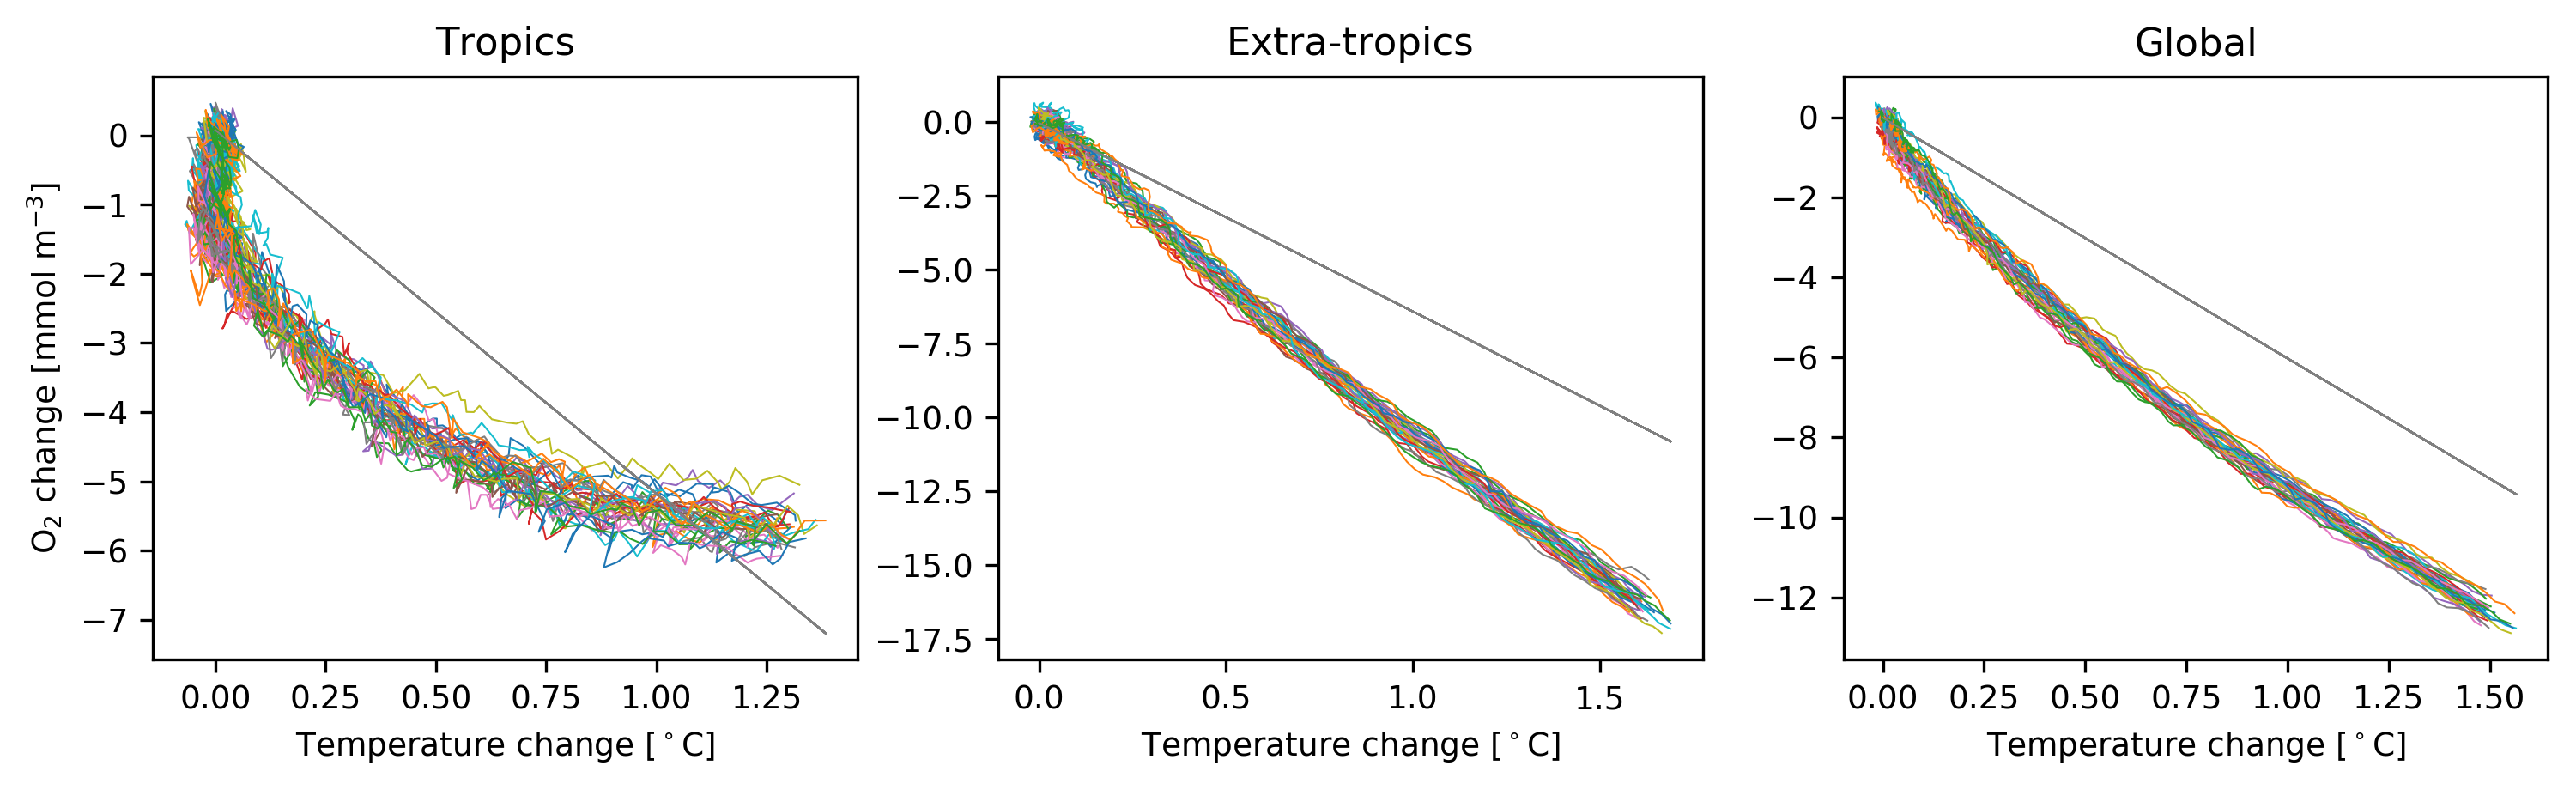

In [16]:
plot_name = os.path.join(diro['fig'],'o2change-temp-phase-diag.pdf')
fig = plt.figure(figsize=(12,3),dpi=300)
gs = gridspec.GridSpec(1,3)
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

cp_sw = 3996.0000 # J/kg/K
rhocp = 1026. * cp_sw * 1e-22 # J/m^3/K

mmol_to_1e14mol = 1e-3 * 1e-14

slope = []
for i in range(len(ds.ens)):
    ax = fig.add_subplot(gs[0,0])
    ax.plot(delta.TEMP[i,:,1],delta.O2[i,:,1],'-',linewidth=0.5)
    ax.plot(O2sat_x[:,1],O2sat_y[:,1],'-',linewidth=0.5,color='gray')
    
    ax = fig.add_subplot(gs[0,1])
    ax.plot(delta.TEMP[i,:,2],delta.O2[i,:,2],'-',linewidth=0.5)
    ax.plot(O2sat_x[:,2],O2sat_y[:,2],'-',linewidth=0.5,color='gray')
    
    ax = fig.add_subplot(gs[0,2])
    ax.plot(delta.TEMP[i,:,0],delta.O2[i,:,0],'-',linewidth=0.5)
    ax.plot(O2sat_x[:,0],O2sat_y[:,0],'-',linewidth=0.5,color='gray')    
    

axs = fig.get_axes()
for i,ax in enumerate(axs):
    ax.set_xlabel('Temperature change [$^\circ$C]')
    if i == 0:
        ax.set_ylabel('O${_{2}}$ change [mmol m$^{-3}$]')

axs[0].set_title('Tropics')
axs[1].set_title('Extra-tropics')
axs[2].set_title('Global')

plt.savefig(plot_name,bbox_inches='tight')

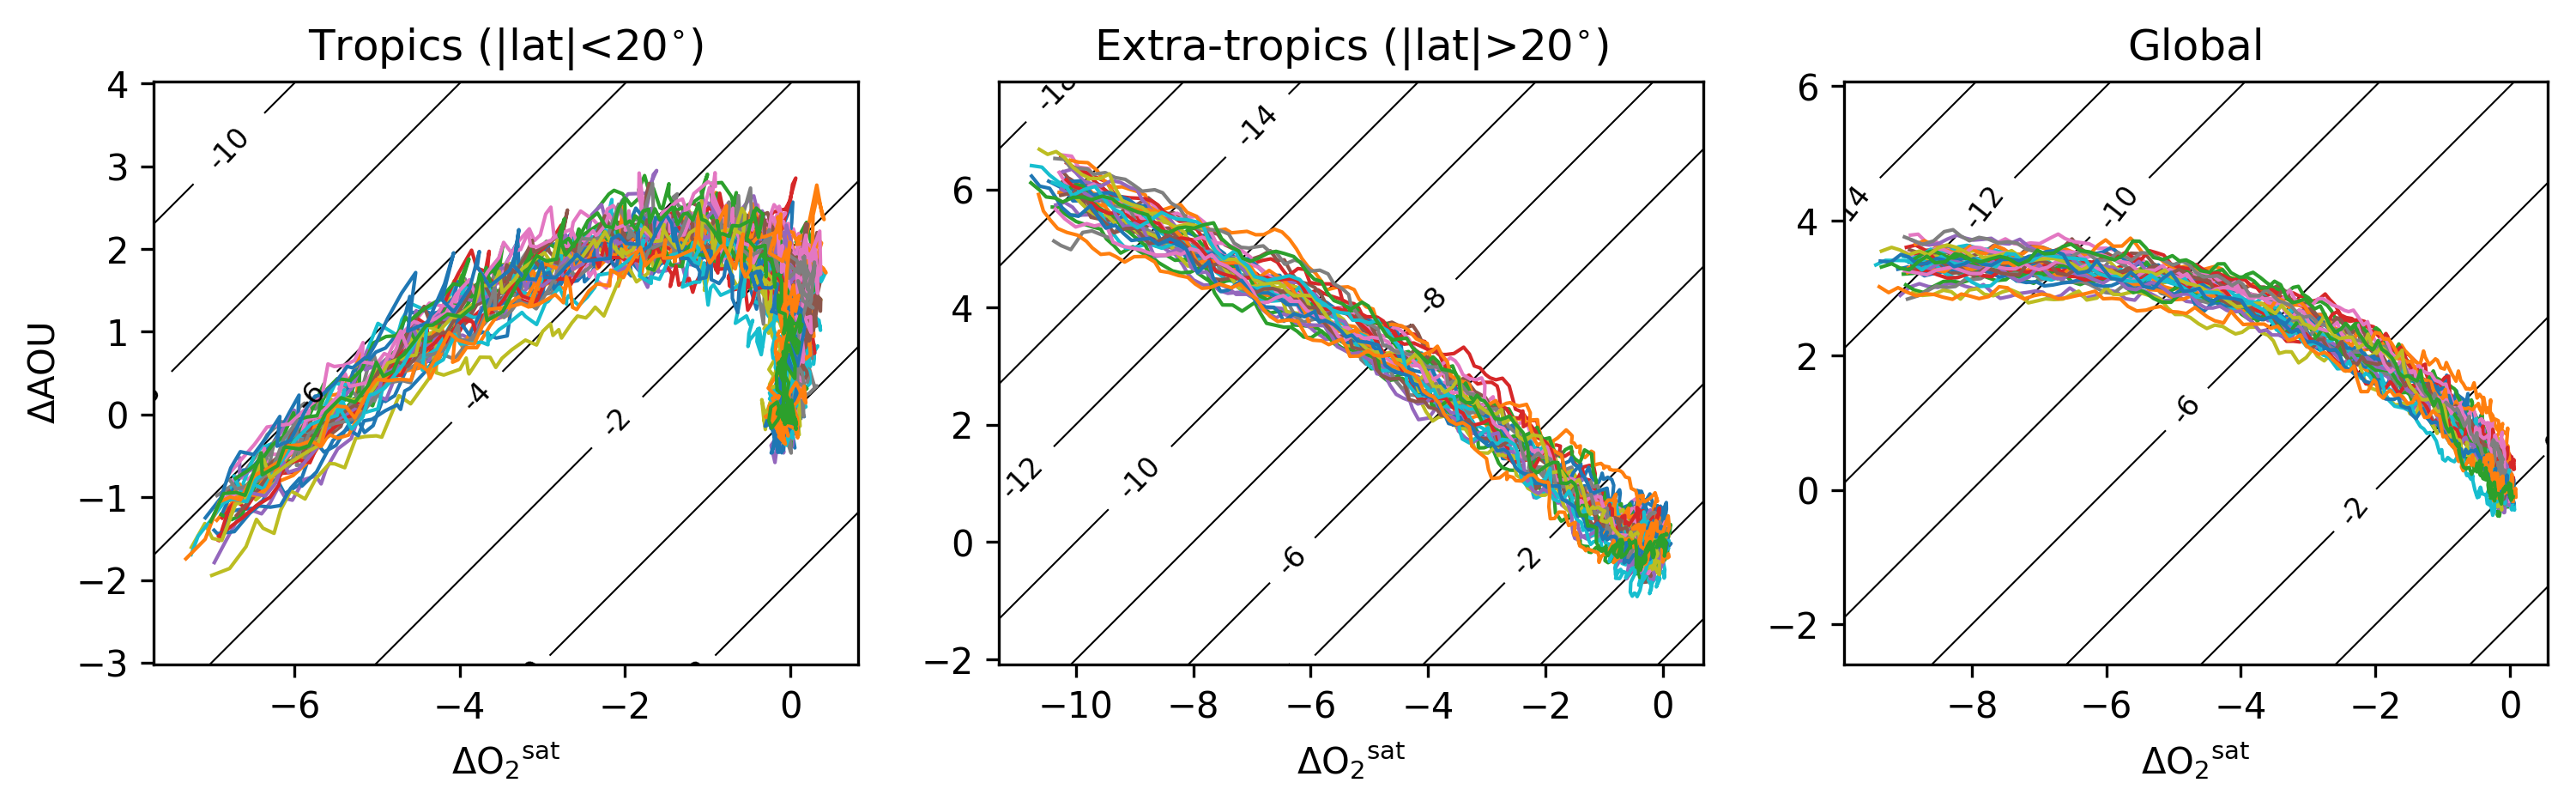

In [19]:
plot_name = os.path.join(diro['fig'],'aou-o2sat-phase-diag.pdf')
fig = plt.figure(figsize=(12,3),dpi=300)
gs = gridspec.GridSpec(1,3)
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

for i in range(len(ds.ens)):
    ax = fig.add_subplot(gs[0,0])
    ax.plot(delta.O2sat[i,:,1],delta.AOU[i,:,1],'-',linewidth=1)
    ax.axis('equal')
    
    ax = fig.add_subplot(gs[0,1])
    ax.plot(delta.O2sat[i,:,2],delta.AOU[i,:,2],'-',linewidth=1)
    ax.axis('equal')        

    ax = fig.add_subplot(gs[0,2])
    ax.plot(delta.O2sat[i,:,0],delta.AOU[i,:,0],'-',linewidth=1)
    ax.axis('equal')
    
axs = fig.get_axes()
for i,ax in enumerate(axs):
    xlm = ax.get_xlim()
    ylm = ax.get_ylim()
    x = np.arange(xlm[0]-3,xlm[1]+3.2,0.2)
    y = np.arange(ylm[0]-3,ylm[1]+3.2,0.2)
    x,y = np.meshgrid(x,y)
    z = x - y
    cs = ax.contour(x,y,z,levels=np.arange(-20,7,2),colors='black',linewidths=0.5,zorder=-10)
    cs.levels = [plot_tools.contour_label_format(val) for val in cs.levels]
    fmt = '%r'
    #-- add contour labels
    lb = plt.clabel(cs, fontsize=8,
                   inline = True,
                   fmt=fmt)
    ax.set_xlim(xlm)
    ax.set_ylim(ylm)
    
    ax.set_xlabel('$\Delta$O${_{2}}^{sat}$')

    if i == 0:
        ax.set_ylabel('$\Delta$$AOU$')
        
axs[0].set_title('Tropics (|lat|<20$^{\circ}$)')
axs[1].set_title('Extra-tropics (|lat|>20$^{\circ}$)')
axs[2].set_title('Global')

plt.savefig(plot_name,bbox_inches='tight')

In [ ]:
dd